# Wasserstein GAN with MNIST

* MNIST data를 가지고 **Wasserstein GAN**를 `tf.contrib.slim`을 이용하여 만들어보자.
  * [참고: TensorFlow slim](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/contrib/slim)

## Import modules

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import time

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.examples.tutorials.mnist import input_data

import tensorflow as tf

slim = tf.contrib.slim
tf.logging.set_verbosity(tf.logging.INFO)

tf.set_random_seed(219)
np.random.seed(219)

os.environ["CUDA_VISIBLE_DEVICES"]="1"

/home/lab4all/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/lab4all/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
FLAGS = tf.app.flags.FLAGS

# Training Flags
tf.app.flags.DEFINE_string('train_dir', 'train/wgan/exp1', '')
tf.app.flags.DEFINE_integer('max_epochs', 50, '')
tf.app.flags.DEFINE_integer('save_epochs', 5, '')
tf.app.flags.DEFINE_integer('summary_steps', 2500, '')
tf.app.flags.DEFINE_integer('print_steps', 1000, '')
tf.app.flags.DEFINE_integer('batch_size', 64, '')
tf.app.flags.DEFINE_float('learning_rate_D', 0.00005, '')
tf.app.flags.DEFINE_float('learning_rate_G', 0.00005, '')
tf.app.flags.DEFINE_integer('k', 1, 'the number of step of learing D before learning G')
tf.app.flags.DEFINE_integer('clip_value', 0.01, 'cliping value for D weights in order to implement 1-Lipshitz function')
tf.app.flags.DEFINE_integer('num_samples', 16, '')

## Import MNIST

In [3]:
data_dir = 'mnist'
mnist = input_data.read_data_sets(data_dir, one_hot=True)
num_examples = len(mnist.train.images)

Extracting mnist/train-images-idx3-ubyte.gz
Extracting mnist/train-labels-idx1-ubyte.gz
Extracting mnist/t10k-images-idx3-ubyte.gz
Extracting mnist/t10k-labels-idx1-ubyte.gz


## Create the model

In [4]:
class WGAN_model(object):
  """Wasserstein GAN
  implementation based on http://arxiv.org/abs/1701.07875
  
  "Wasserstein GAN"
  Martin Arjovsky, Soumith Chintala, and L\'eon Bottou
  """
  
  def __init__(self, mode):
    """Basic setup.
    
    Args:
      mode: "train" or "generate"
    """
    assert mode in ["train", "generate"]
    self.mode = mode
    
    # hyper-parameters for model
    self.x_dim = 784
    self.z_dim = 100
    self.batch_size = FLAGS.batch_size
    self.num_samples = FLAGS.num_samples
    
    # Global step Tensor.
    self.global_step = None
    
    print('The mode is %s.' % self.mode)
    print('complete initializing model.')
    
    
  def build_inputs(self):
    """Build random_z.
    
    Returns:
      A float32 Tensor with [batch_size, 1, 1, z_dim]
    """
    # Setup variable of random vector z
    with tf.variable_scope('random_z'):
      self.random_z = tf.placeholder(tf.float32, [None, self.z_dim])

    return self.random_z
  
  
  def read_MNIST(self):
    # Setup placeholder of real data (MNIST)
    with tf.variable_scope('mnist'):
      self.mnist = tf.placeholder(tf.float32, [None, self.x_dim])
      self.mnist_image = tf.reshape(self.mnist, [-1, 28, 28, 1])
      
      return self.mnist_image


  def Generator(self, random_z, is_training=True, reuse=False):
    """Generator setup.
    
    Args:
      random_z: A float32 Tensor random vector (latent code)
      is_training: boolean whether training mode or generating mode
      reuse: variables reuse flag
      
    Returns:
      A float32 scalar Tensor of generated images from random vector
    """
    with tf.variable_scope('Generator') as scope:
      if reuse:
        scope.reuse_variables()

      batch_norm_params = {'decay': 0.9,
                           'epsilon': 0.001,
                           'is_training': is_training,
                           'scope': 'batch_norm'}
      with slim.arg_scope([slim.conv2d_transpose],
                          kernel_size=[4, 4],
                          stride=[2, 2],
                          normalizer_fn=slim.batch_norm,
                          normalizer_params=batch_norm_params):

        # Use full conv2d_transpose instead of projection and reshape
        # random_z: 100 dim
        self.inputs = tf.reshape(random_z, [-1, 1, 1, self.z_dim])
        # inputs = 1 x 1 x 100 dim
        self.layer1 = slim.conv2d_transpose(inputs=self.inputs,
                                            num_outputs=256,
                                            kernel_size=[3, 3],
                                            padding='VALID',
                                            scope='layer1')
        # layer1: 3 x 3 x 256 dim
        self.layer2 = slim.conv2d_transpose(inputs=self.layer1,
                                            num_outputs=128,
                                            kernel_size=[3, 3],
                                            padding='VALID',
                                            scope='layer2')
        # layer2: 7 x 7 x 128 dim
        self.layer3 = slim.conv2d_transpose(inputs=self.layer2,
                                            num_outputs=64,
                                            scope='layer3')
        # layer3: 14 x 14 x 64 dim
        self.layer4 = slim.conv2d_transpose(inputs=self.layer3,
                                            num_outputs=1,
                                            normalizer_fn=None,
                                            activation_fn=tf.sigmoid,
                                            scope='layer4')
        # output = layer4: 28 x 28 x 1 dim
        generated_data = self.layer4

        return generated_data
    
    
  def Discriminator(self, data, reuse=False):
    """Discriminator setup.
    
    Args:
      data: A float32 scalar Tensor of real data
      reuse: variables reuse flag
      
    Returns:
      logits: A float32 scalar Tensor
    """
    with tf.variable_scope('Discriminator') as scope:
      if reuse:
        scope.reuse_variables()
        
      batch_norm_params = {'decay': 0.9,
                           'epsilon': 0.001,
                           'scope': 'batch_norm'}
      with slim.arg_scope([slim.conv2d],
                          kernel_size=[4, 4],
                          stride=[2, 2],
                          activation_fn=tf.nn.leaky_relu,
                          normalizer_fn=slim.batch_norm,
                          normalizer_params=batch_norm_params):

        # data: 28 x 28 x 1 dim
        self.layer1 = slim.conv2d(inputs=data,
                                  num_outputs=64,
                                  normalizer_fn=None,
                                  scope='layer1')
        # layer1: 14 x 14 x 64 dim
        self.layer2 = slim.conv2d(inputs=self.layer1,
                                  num_outputs=128,
                                  scope='layer2')
        # layer2: 7 x 7 x 128 dim
        self.layer3 = slim.conv2d(inputs=self.layer2,
                                  num_outputs=256,
                                  kernel_size=[3, 3],
                                  padding='VALID',
                                  scope='layer3')
        # layer3: 3 x 3 x 256 dim
        self.layer4 = slim.conv2d(inputs=self.layer3,
                                  num_outputs=1,
                                  kernel_size=[3, 3],
                                  stride=[1, 1],
                                  padding='VALID',
                                  normalizer_fn=None,
                                  activation_fn=None,
                                  scope='layer4')
        # logits = layer4: 1 x 1 x 1 dim
        discriminator_logits = tf.squeeze(self.layer4, axis=[1, 2])

        return discriminator_logits
    
    
  def setup_global_step(self):
    """Sets up the global step Tensor."""
    if self.mode == "train":
      self.global_step = tf.Variable(initial_value=0,
                                     name='global_step',
                                     trainable=False,
                                     collections=[tf.GraphKeys.GLOBAL_STEP,
                                                  tf.GraphKeys.GLOBAL_VARIABLES])
      
      print('complete setup global_step.')
      

  def WGANLoss(self, logits, is_real=True, scope=None):
    """Computes Wasserstain GAN loss
    
    Args:
      logits: A float32 Tensor of logits.
      is_real: boolean, Treu means `-` sign, False means `+` sign.
      
    Returns:
      A scalar Tensor representing the loss value.
    """
    with tf.variable_scope(scope):
      loss = tf.reduce_mean(logits)
      if is_real:
        loss = -loss

    return loss
  
  
  def GANLoss(self, logits, is_real=True, scope=None):
    """Computes standard GAN loss between `logits` and `labels`.
    
    Args:
      logits: A float32 Tensor of logits.
      is_real: boolean, Treu means `1` labeling, False means `0` labeling.
      
    Returns:
      A scalar Tensor representing the loss value.
    """
    if is_real:
      labels = tf.ones_like(logits)
    else:
      labels = tf.zeros_like(logits)

    loss = tf.losses.sigmoid_cross_entropy(multi_class_labels=labels,
                                           logits=logits,
                                           scope=scope)

    return loss

      
  def build(self):
    """Creates all ops for training or generate."""
    self.setup_global_step()
    
    
    if self.mode == "generate":
      pass
    
    else:
      # generating random vector
      self.random_z = self.build_inputs()
      # generating images from Generator() via random vector z
      self.generated_data = self.Generator(self.random_z)
      
      # read dataset
      self.real_data = self.read_MNIST()
      
      # discriminating real data by Discriminator()
      self.real_logits = self.Discriminator(self.real_data)
      # discriminating fake data (generated)_images) by Discriminator()
      self.fake_logits = self.Discriminator(self.generated_data, reuse=True)
      
      # WGAN loss of real data
      self.loss_real = self.WGANLoss(logits=self.real_logits, is_real=True, scope='loss_D_real')
      # WGAN loss of fake data
      self.loss_fake = self.WGANLoss(logits=self.fake_logits, is_real=False, scope='loss_D_fake')
      
      # loss of Discriminator
      with tf.variable_scope('loss_D'):
        self.loss_Discriminator = self.loss_real + self.loss_fake
      # loss of Generator that used to fool the Discriminator
      self.loss_Generator = self.WGANLoss(logits=self.fake_logits, is_real=True, scope='loss_G')
      
      # Separate variables for each function
      self.D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Discriminator')
      self.G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Generator')
      
      # Clip the weights for D to implement 1-Lipshitz function
      self.D_cliping = [d_var.assign(tf.clip_by_value(d_var, -FLAGS.clip_value, FLAGS.clip_value))
                          for d_var in self.D_vars]
      
      
      # generating images for sample
      self.sample_data = self.Generator(self.random_z, is_training=False, reuse=True)

      # write summaries
      tf.summary.scalar('losses/loss_Discriminator', self.loss_Discriminator)
      tf.summary.scalar('losses/loss_Generator', self.loss_Generator)
      tf.summary.scalar('losses/Wasserstein_estimate', -self.loss_Discriminator)
      
      # Add histogram summaries
      for var in self.D_vars:
        tf.summary.histogram(var.op.name, var)
      for var in self.G_vars:
        tf.summary.histogram(var.op.name, var)
        
      # Add image summaries
      tf.summary.image('random_images', self.generated_data, max_outputs=4)
      #tf.summary.image('real_images', self.real_data)
      
    print('complete model build.\n')

## Define plot function

In [5]:
def print_sample_data(sample_data, max_print=FLAGS.num_samples):
  print_images = sample_data[:max_print,:]
  print_images = print_images.reshape([max_print, 28, 28])
  print_images = print_images.swapaxes(0, 1)
  print_images = print_images.reshape([28, max_print * 28])
  
  plt.figure(figsize=(max_print, 1))
  plt.axis('off')
  plt.imshow(print_images, cmap='gray')
  plt.show()

## Build a model

In [6]:
model = WGAN_model(mode="train")
model.build()

# show info for trainable variables
t_vars = tf.trainable_variables()
slim.model_analyzer.analyze_vars(t_vars, print_info=True)

The mode is train.
complete initializing model.
complete setup global_step.
complete model build.

---------
Variables: name (type shape) [size]
---------
Generator/layer1/weights:0 (float32_ref 3x3x256x100) [230400, bytes: 921600]
Generator/layer1/batch_norm/beta:0 (float32_ref 256) [256, bytes: 1024]
Generator/layer2/weights:0 (float32_ref 3x3x128x256) [294912, bytes: 1179648]
Generator/layer2/batch_norm/beta:0 (float32_ref 128) [128, bytes: 512]
Generator/layer3/weights:0 (float32_ref 4x4x64x128) [131072, bytes: 524288]
Generator/layer3/batch_norm/beta:0 (float32_ref 64) [64, bytes: 256]
Generator/layer4/weights:0 (float32_ref 4x4x1x64) [1024, bytes: 4096]
Generator/layer4/biases:0 (float32_ref 1) [1, bytes: 4]
Discriminator/layer1/weights:0 (float32_ref 4x4x1x64) [1024, bytes: 4096]
Discriminator/layer1/biases:0 (float32_ref 64) [64, bytes: 256]
Discriminator/layer2/weights:0 (float32_ref 4x4x64x128) [131072, bytes: 524288]
Discriminator/layer2/batch_norm/beta:0 (float32_ref 128) [

(1087618, 4350472)

In [7]:
#opt_D = tf.train.AdamOptimizer(learning_rate=FLAGS.learning_rate_D, beta1=0.5)
#opt_G = tf.train.AdamOptimizer(learning_rate=FLAGS.learning_rate_G, beta1=0.5)
opt_D = tf.train.RMSPropOptimizer(learning_rate=FLAGS.learning_rate_D)
opt_G = tf.train.RMSPropOptimizer(learning_rate=FLAGS.learning_rate_G)

In [8]:
with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
  opt_D_op = opt_D.minimize(model.loss_Discriminator, var_list=model.D_vars)
  opt_G_op = opt_G.minimize(model.loss_Generator, global_step=model.global_step,
                            var_list=model.G_vars)

In [9]:
saver = tf.train.Saver(tf.global_variables(), max_to_keep=1000)

summary_op = tf.summary.merge_all()

sv = tf.train.Supervisor(logdir=FLAGS.train_dir,
                         summary_op=None,
                         saver=saver,
                         save_model_secs=0,
                         init_fn=None)

INFO:tensorflow:Starting standard services.
INFO:tensorflow:Starting queue runners.
INFO:tensorflow:global_step/sec: 0
INFO:tensorflow:Start Session.
Epochs: 1.163 global step: 1000  Wasserstein estimation: 14.5134 (4848.4 examples/sec; 0.013 sec/batch)


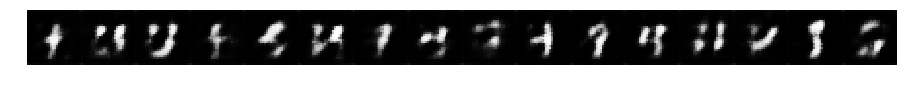

Epochs: 2.327 global step: 2000  Wasserstein estimation: 5.78067 (4479.6 examples/sec; 0.014 sec/batch)


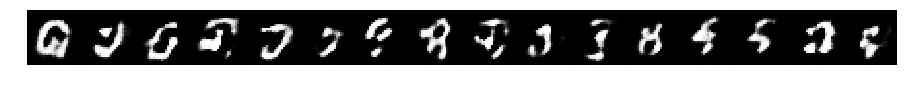

Epochs: 3.491 global step: 3000  Wasserstein estimation: 3.51545 (4362.7 examples/sec; 0.015 sec/batch)


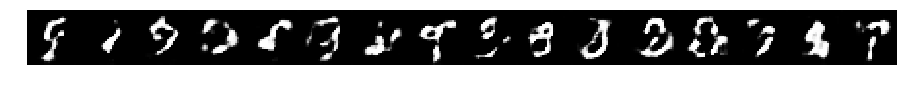

Epochs: 4.655 global step: 4000  Wasserstein estimation: 3.02127 (4335.4 examples/sec; 0.015 sec/batch)


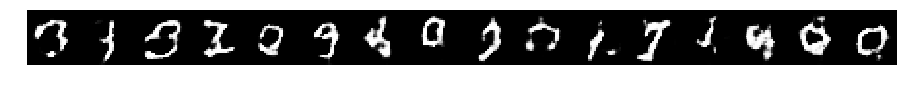

INFO:tensorflow:Saving model with global step 4296 (= 5 epochs) to disk.
Epochs: 5.819 global step: 5000  Wasserstein estimation: 2.16337 (4456.7 examples/sec; 0.014 sec/batch)


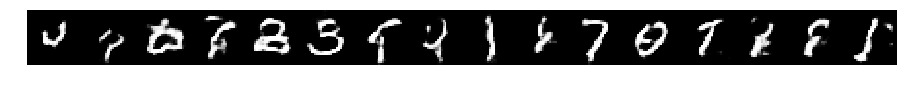

Epochs: 6.983 global step: 6000  Wasserstein estimation: 1.91082 (4419.3 examples/sec; 0.014 sec/batch)


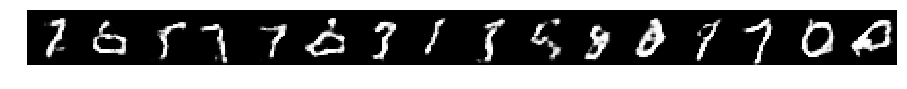

Epochs: 8.148 global step: 7000  Wasserstein estimation: 1.55075 (4283.4 examples/sec; 0.015 sec/batch)


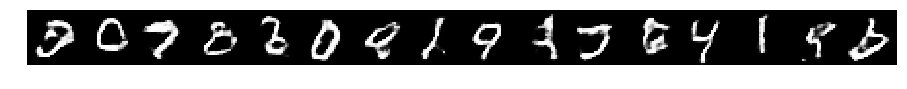

Epochs: 9.312 global step: 8000  Wasserstein estimation: 2.28017 (4358.4 examples/sec; 0.015 sec/batch)


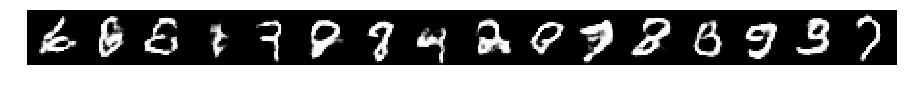

INFO:tensorflow:global_step/sec: 69.6083
INFO:tensorflow:Saving model with global step 8591 (= 10 epochs) to disk.
Epochs: 10.476 global step: 9000  Wasserstein estimation: 1.88877 (4409.0 examples/sec; 0.015 sec/batch)


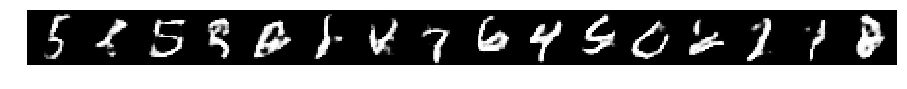

Epochs: 11.640 global step: 10000  Wasserstein estimation: 1.54936 (4319.1 examples/sec; 0.015 sec/batch)


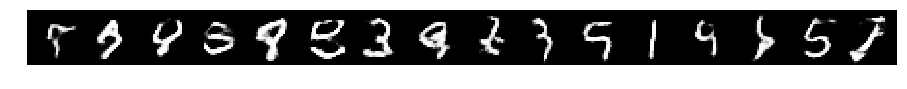

Epochs: 12.804 global step: 11000  Wasserstein estimation: 0.948634 (4660.3 examples/sec; 0.014 sec/batch)


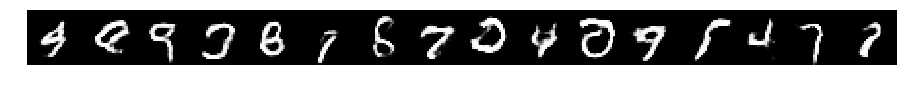

Epochs: 13.968 global step: 12000  Wasserstein estimation: 1.58258 (4329.0 examples/sec; 0.015 sec/batch)


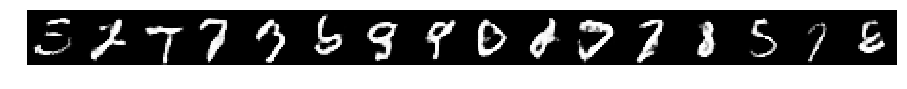

INFO:tensorflow:Saving model with global step 12886 (= 15 epochs) to disk.
Epochs: 15.133 global step: 13000  Wasserstein estimation: 1.37236 (4205.5 examples/sec; 0.015 sec/batch)


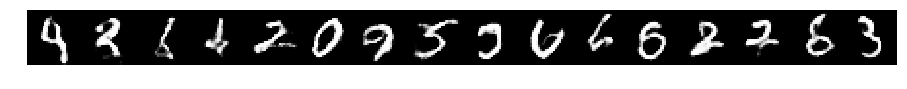

Epochs: 16.297 global step: 14000  Wasserstein estimation: 1.83993 (4448.2 examples/sec; 0.014 sec/batch)


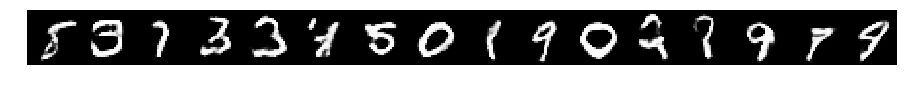

Epochs: 17.461 global step: 15000  Wasserstein estimation: 1.73657 (4591.1 examples/sec; 0.014 sec/batch)


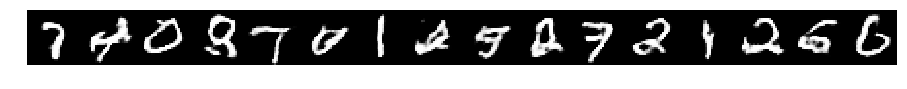

Epochs: 18.625 global step: 16000  Wasserstein estimation: 1.24531 (4522.3 examples/sec; 0.014 sec/batch)


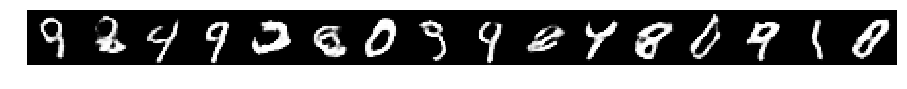

INFO:tensorflow:global_step/sec: 68.6084
Epochs: 19.789 global step: 17000  Wasserstein estimation: 0.753147 (4586.9 examples/sec; 0.014 sec/batch)


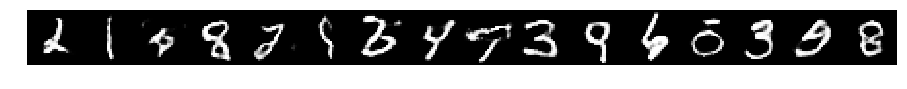

INFO:tensorflow:Saving model with global step 17181 (= 20 epochs) to disk.
Epochs: 20.953 global step: 18000  Wasserstein estimation: 1.11314 (4643.2 examples/sec; 0.014 sec/batch)


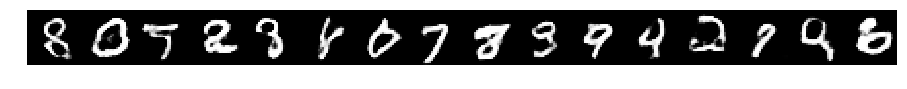

Epochs: 22.118 global step: 19000  Wasserstein estimation: 0.967828 (4759.0 examples/sec; 0.013 sec/batch)


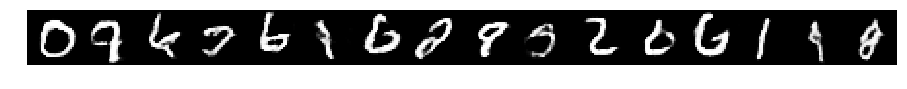

Epochs: 23.282 global step: 20000  Wasserstein estimation: 1.44694 (4495.1 examples/sec; 0.014 sec/batch)


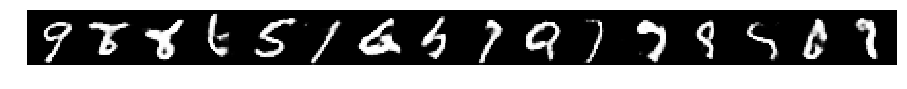

Epochs: 24.446 global step: 21000  Wasserstein estimation: 1.30653 (4494.7 examples/sec; 0.014 sec/batch)


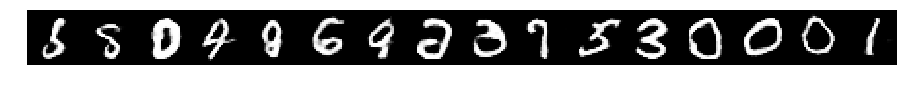

INFO:tensorflow:Saving model with global step 21476 (= 25 epochs) to disk.
Epochs: 25.610 global step: 22000  Wasserstein estimation: 1.02279 (4522.2 examples/sec; 0.014 sec/batch)


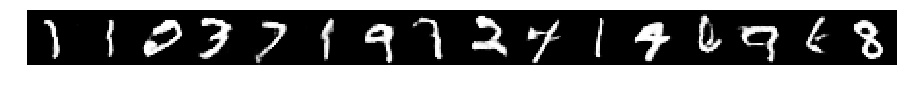

Epochs: 26.774 global step: 23000  Wasserstein estimation: 1.17621 (4678.5 examples/sec; 0.014 sec/batch)


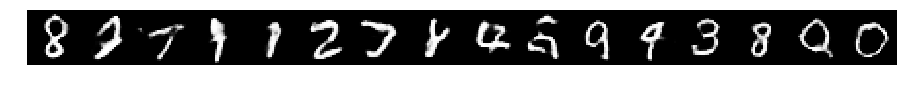

Epochs: 27.938 global step: 24000  Wasserstein estimation: 1.6658 (4549.5 examples/sec; 0.014 sec/batch)


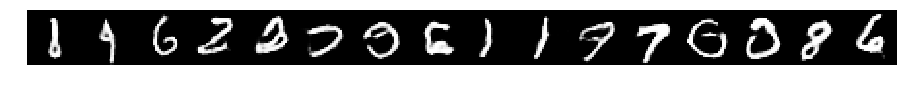

Epochs: 29.102 global step: 25000  Wasserstein estimation: 1.15255 (4867.7 examples/sec; 0.013 sec/batch)


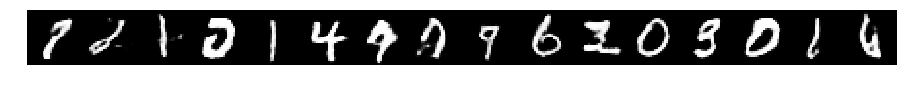

INFO:tensorflow:global_step/sec: 70.1166
INFO:tensorflow:Saving model with global step 25771 (= 30 epochs) to disk.
Epochs: 30.266 global step: 26000  Wasserstein estimation: 1.37337 (4570.0 examples/sec; 0.014 sec/batch)


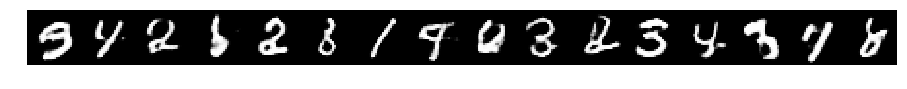

Epochs: 31.431 global step: 27000  Wasserstein estimation: 1.089 (4664.5 examples/sec; 0.014 sec/batch)


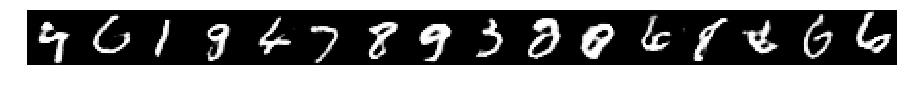

Epochs: 32.595 global step: 28000  Wasserstein estimation: 1.12564 (4598.7 examples/sec; 0.014 sec/batch)


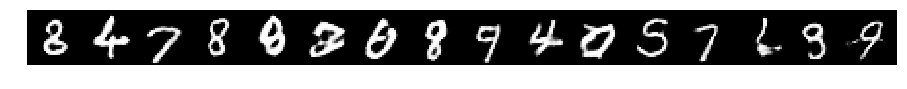

Epochs: 33.759 global step: 29000  Wasserstein estimation: 1.0574 (4675.8 examples/sec; 0.014 sec/batch)


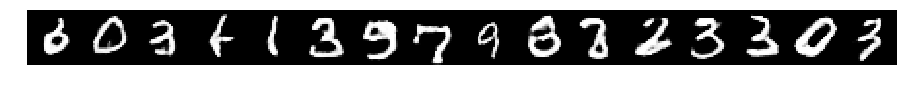

Epochs: 34.923 global step: 30000  Wasserstein estimation: 0.641896 (4591.3 examples/sec; 0.014 sec/batch)


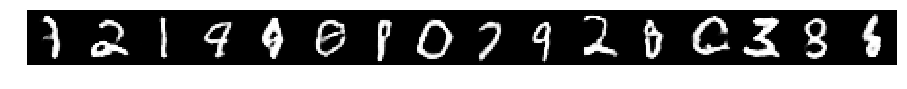

INFO:tensorflow:Saving model with global step 30066 (= 35 epochs) to disk.
Epochs: 36.087 global step: 31000  Wasserstein estimation: 1.04886 (4827.5 examples/sec; 0.013 sec/batch)


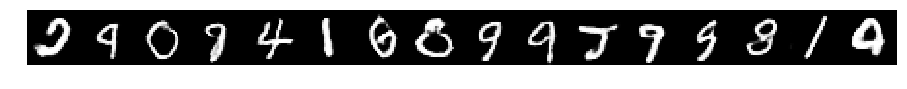

Epochs: 37.251 global step: 32000  Wasserstein estimation: 1.29502 (4641.4 examples/sec; 0.014 sec/batch)


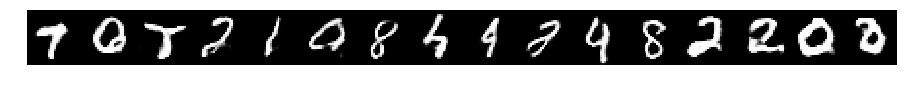

Epochs: 38.415 global step: 33000  Wasserstein estimation: 1.01886 (4709.4 examples/sec; 0.014 sec/batch)


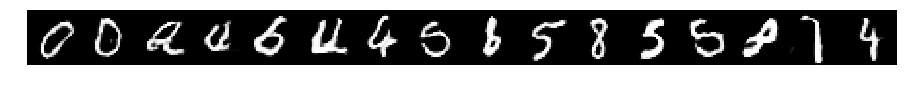

INFO:tensorflow:global_step/sec: 71.0001
Epochs: 39.579 global step: 34000  Wasserstein estimation: 0.956413 (4680.8 examples/sec; 0.014 sec/batch)


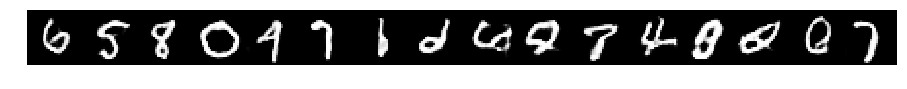

INFO:tensorflow:Saving model with global step 34361 (= 40 epochs) to disk.
Epochs: 40.744 global step: 35000  Wasserstein estimation: 0.755321 (4564.8 examples/sec; 0.014 sec/batch)


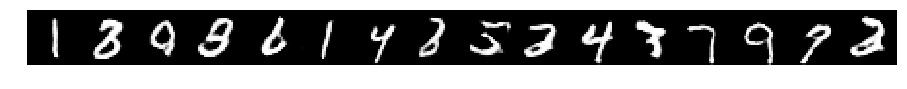

Epochs: 41.908 global step: 36000  Wasserstein estimation: 1.16168 (4708.9 examples/sec; 0.014 sec/batch)


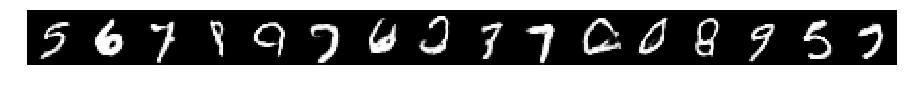

Epochs: 43.072 global step: 37000  Wasserstein estimation: 1.11184 (4987.7 examples/sec; 0.013 sec/batch)


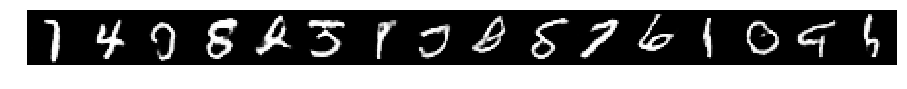

Epochs: 44.236 global step: 38000  Wasserstein estimation: 1.30393 (4691.0 examples/sec; 0.014 sec/batch)


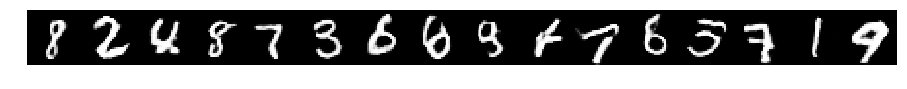

INFO:tensorflow:Saving model with global step 38656 (= 45 epochs) to disk.
Epochs: 45.400 global step: 39000  Wasserstein estimation: 0.917485 (4538.8 examples/sec; 0.014 sec/batch)


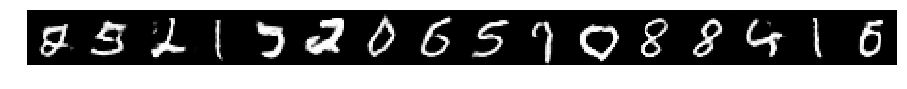

Epochs: 46.564 global step: 40000  Wasserstein estimation: 1.05366 (4668.4 examples/sec; 0.014 sec/batch)


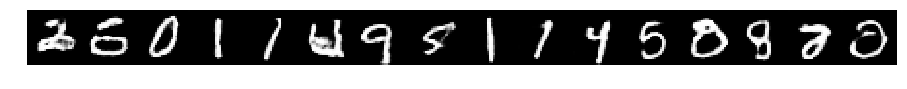

Epochs: 47.728 global step: 41000  Wasserstein estimation: 1.28101 (4798.3 examples/sec; 0.013 sec/batch)


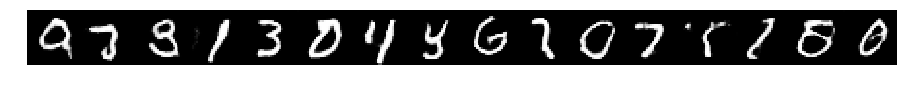

Epochs: 48.893 global step: 42000  Wasserstein estimation: 1.39971 (4866.6 examples/sec; 0.013 sec/batch)


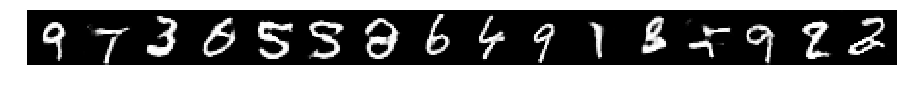

INFO:tensorflow:global_step/sec: 71.5584
INFO:tensorflow:Saving model with global step 42951 (= 50 epochs) to disk.
INFO:tensorflow:complete training...


In [10]:
sess_config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
with sv.managed_session(config=sess_config) as sess:
  tf.logging.info('Start Session.')
  
  #sv.start_queue_runners(sess=sess)
  #tf.logging.info('Starting Queues.')

  num_batches_per_epoch = num_examples / FLAGS.batch_size

  # save loss values for plot
  losses = []
  for epoch in range(FLAGS.max_epochs+1):
    for j in range(int(num_batches_per_epoch)):
      start_time = time.time()
      if sv.should_stop():
        break

      for _ in range(FLAGS.k):
        mnist_batch = mnist.train.next_batch(FLAGS.batch_size)
        random_z = np.random.uniform(low=-1., high=1., size=[FLAGS.batch_size, model.z_dim])

        _, _, loss_D = sess.run([opt_D_op, model.D_cliping, model.loss_Discriminator],
                                feed_dict={model.mnist: mnist_batch[0],
                                           model.random_z: random_z})
      _, _global_step, loss_G = sess.run([opt_G_op,
                                          sv.global_step,
                                          model.loss_Generator],
                                          feed_dict={model.mnist: mnist_batch[0],
                                                     model.random_z: random_z})

      epochs = epoch + j / num_batches_per_epoch
      duration = time.time() - start_time

      if _global_step % FLAGS.print_steps == 0:
        examples_per_sec = FLAGS.batch_size / float(duration)
        print("Epochs: %.3f global step: %d  Wasserstein estimation: %g (%.1f examples/sec; %.3f sec/batch)"
                % (epochs, _global_step, -loss_D, examples_per_sec, duration))

        losses.append([epochs, -loss_D])

        # print sample data
        sample_random_z = np.random.uniform(low=-1., high=1., size=[FLAGS.num_samples, model.z_dim])
        sample_data = sess.run(model.sample_data, feed_dict={model.random_z: sample_random_z})
        print_sample_data(sample_data)
        
      # write summaries periodically
      if _global_step % FLAGS.summary_steps == 0:
        summary_str = sess.run(summary_op, feed_dict={model.mnist: mnist_batch[0],
                                                      model.random_z: random_z})
        sv.summary_computed(sess, summary_str)

      # save model checkpoint periodically
      if epoch != 0  and  epoch % FLAGS.save_epochs == 0  and  j == 0:
        tf.logging.info('Saving model with global step %d (= %d epochs) to disk.' % (_global_step, epoch))
        sv.saver.save(sess, sv.save_path, global_step=sv.global_step)
      if epoch == FLAGS.max_epochs:
        break
      
  tf.logging.info('complete training...')

# Plot loss functions

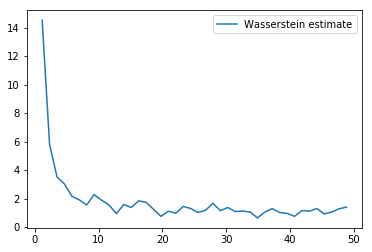

In [11]:
losses = np.asarray(losses)

plt.plot(losses[:,0], losses[:,1], label='Wasserstein estimate')
plt.legend(loc='upper right')
plt.show()